# Comparing overturning circulation in ACCESS-OM3 with ACCESS-OM2

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [1]:
# Parameters – this is the ONLY place you should edit
# when switching models / experiments / obs datasets.

### USER EDIT start

# ESM datastore (model output) – change this for a different run/model
esm_file = "/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json"
#esm_file = "/g/data/zv30/non-cmip/ACCESS-CM3/cm3-run-20-01-2026-om3-update/cm3-datastore/cm3-datastore.json"

# What physical field you want, in CF terms (stays the same across models)
variable_standard_name = "Ocean Mass Y Transport"

# Fallback variable name to use if the catalog doesn’t expose standard_name
fallback_variable_names = ["vmo"]

# Frequency depends on the datastore you’re using:
data_frequency = "1mon"

# Optional special-case switches (e.g. 25 km quirks)
APPLY_OBS_25KM_Y_SLICE = False

# Plot settings
dpi = 300

### USER EDIT stop

import os
import sys
from matplotlib import rcParams

# Change working directory to the notebooks folder in the repo
project_root = f"/g/data/tm70/{os.environ['USER']}/access-om3-paper-1"
notebooks_dir = os.path.join(project_root, "notebooks")

# This makes CWD match where SST.ipynb and exptdata_access.py live
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())

from exptdata_access import get_experiment_info, guess_experiment_from_esm_file
from model_agnostic import get_lon_lat_from_catalog, select_variable, ensure_2d_transport

%matplotlib inline
rcParams["figure.dpi"] = dpi

plotfolder = f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

# Infer model information from the datastore path
expt_key, info = guess_experiment_from_esm_file(esm_file)

model_name = info["model"]             # OM3 or CM3
exptname = os.path.basename(os.path.dirname(esm_file))
print(f"Running notebook for model: {model_name}")
print("ESM datastore path:", esm_file)
print("Plot folder path:", plotfolder)
print("Experiment name:", exptname)

Changed working directory to: /g/data/tm70/ek4684/access-om3-paper-1/notebooks
Running notebook for model: ACCESS-OM3
ESM datastore path: /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path: /g/data/tm70/ek4684/access-om3-paper-figs/
Experiment name: MC_25km_jra_iaf-1.0-beta-5165c0f8


In [2]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime
import cartopy.crs as ccrs
import os
import cartopy.feature as cft
from textwrap import wrap
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
import glob
import re
from pint import application_registry as ureg
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [ ]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

In [4]:
RYF = esm_file.find('ryf') > 0
RYF

False

In [5]:
def load_cm2(pattern, varname, rename_dims=None, drop_vars=(), time_slice=None):
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files matched: {pattern}")

    def _ym_from_filename(fname):
        base = os.path.basename(fname)
        m = re.search(r"ym_(\d+)_(\d+)\.nc$", base)
        if not m:
            raise ValueError(f"Could not parse year/month from filename: {base}")
        return int(m.group(1)), int(m.group(2))

    def _to_ym_key(dt):
        if hasattr(dt, "year") and hasattr(dt, "month"):
            return int(dt.year) * 12 + int(dt.month)
        raise TypeError(f"Unsupported time value for mapping: {dt!r}")

    if time_slice is not None and getattr(time_slice, "start", None) is not None and getattr(time_slice, "stop", None) is not None:
        start_key = _to_ym_key(time_slice.start)
        stop_key = _to_ym_key(time_slice.stop)
        if stop_key < start_key:
            start_key, stop_key = stop_key, start_key

        ym_keys = []
        for f in files:
            y, m = _ym_from_filename(f)
            ym_keys.append(y * 12 + m)

        diffs = [b - a for a, b in zip(ym_keys[:-1], ym_keys[1:]) if b > a]
        file_span_months = max(1, min(diffs) if diffs else 1)

        def _select_files(shift_months=0):
            return [
                f
                for f, key in zip(files, ym_keys)
                if (key + shift_months) <= stop_key
                and (key + shift_months + file_span_months - 1) >= start_key
            ]

        subset = _select_files(0)
        shift_used = 0

        if not subset:
            file_min = min(ym_keys)
            file_max = max(ym_keys) + file_span_months - 1
            for shift in (stop_key - file_max, start_key - file_min):
                if shift == 0:
                    continue
                candidate = _select_files(shift)
                if candidate:
                    subset = candidate
                    shift_used = shift
                    break

        if not subset:
            raise RuntimeError(
                f"load_cm2[{varname}]: could not map timerange to filenames; refusing to open all {len(files)} files"
            )

        print(f"load_cm2[{varname}]: using {len(subset)}/{len(files)} files")
        if shift_used:
            print(f"load_cm2[{varname}]: shifted window by {shift_used} months")
        files = subset

    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    open_kwargs = dict(
        combine="nested",
        concat_dim="time",
        parallel=False,
        engine="netcdf4",
        chunks={"time": 12},
        drop_variables=drop_vars,
        decode_times=time_coder,
        decode_timedelta=True,
        decode_coords=False,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        join="override",
        create_default_indexes=False,
    )

    try:
        ds = xr.open_mfdataset(files, **open_kwargs)
    except TypeError:
        open_kwargs.pop("create_default_indexes", None)
        ds = xr.open_mfdataset(files, **open_kwargs)

    da = ds[varname]

    if "time" in da.dims:
        da = da.sortby("time")

    if rename_dims:
        present = {k: v for k, v in rename_dims.items() if k in da.dims}
        da = da.rename(present)

    return da

## Load ACCESS-OM3 data from ESM datastore

In [6]:
exptname=os.path.basename(os.path.dirname(esm_file))
print("Experiment name:", exptname)

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

Experiment name: MC_25km_jra_iaf-1.0-beta-5165c0f8


In [7]:
if model_name == "ACCESS-OM3":
    da_model = select_variable(
        datastore,
        variable_standard_name=variable_standard_name,
        fallback_variable_names=fallback_variable_names,
        data_frequency=data_frequency,
    )
elif model_name == "ACCESS-CM3":
    da_model = select_variable(
        datastore,
        variable_standard_name=variable_standard_name,
        fallback_variable_names=fallback_variable_names,
        data_frequency=data_frequency,
        chunks={"time": 1},
    )
print("Selected variable:", da_model.name)
print("dims:", da_model.dims)

CF-based lookup failed: ValueError('No entries found for this CF standard_name.')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xarray/backends/plugins.py:109: RuntimeWarning: Engine 'argo' loading failed:
Expecting value: line 1 column 1 (char 0)
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)
/opt/conda/analysis3-25.10/bin/gmt: error while loading shared libraries: /opt/conda/analysis3-25.10/bin/../lib/./libglib-2.0.so.0: cannot read file data: Input/output error


Selected variable via fallback name: vmo
Selected variable: vmo
dims: ('time', 'rho2_l', 'yq', 'xh')


In [8]:
# Discover lon/lat from the catalog (using the helper we wrote earlier)
lon, lat = get_lon_lat_from_catalog(datastore)

# Ensure model_all has CF longitude/latitude coords
try:
    # If CF coords already exist, just use them
    _ = da_model.cf["longitude"]
    _ = da_model.cf["latitude"]
    model_all = da_model
    print("Using existing CF longitude/latitude on da_model.")
except KeyError:
    # Otherwise, attach the lon/lat we discovered
    model_all = da_model.cf.assign_coords(
        {
            "longitude": lon,
            "latitude": lat,
        }
    )
    print("Attached longitude/latitude from catalog grid variables.")

print("model_all dims:", model_all.dims)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Using existing CF longitude/latitude on da_model.
model_all dims: ('time', 'rho2_l', 'yq', 'xh')


In [9]:
vmo_all = model_all.sel(yq=slice(None, 65)) # omit tripolar region https://github.com/COSIMA/cosima-recipes/issues/510

In [10]:
##### ONLY NEEDED FOR 25km-iaf-test-for-AK-expt-7df5ef4c !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
if exptname == "25km-iaf-test-for-AK-expt-7df5ef4c":
    vmo_all = vmo_all.isel(yq=slice(10, None))

### Load and plot data from ACCESS-OM2
use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258#p-747-ryf-7

In [11]:
if model_name == 'ACCESS-OM3':
    if not RYF:
        om2exptname = '025deg_jra55_iaf_omip2_cycle1'
        frequency = '1mon'
    else:
        om2exptname = '025deg_jra55_ryf9091_gadi' # Note that this simulation doesn't have the GM component of the overturning as a diagnostic - it has GM switched on, but not diagnosed.
        frequency='1yr' # for 025deg_jra55_ryf9091_gadi

    datastore = intake.cat.access_nri[om2exptname]

elif model_name == 'ACCESS-CM3':
    om2exptname = 'cj877'


In [12]:
if model_name == "ACCESS-OM3":
    data_name = 'ACCESS-OM2'
    ty_trans_rho_all = datastore.search(
                                variable='ty_trans_rho',
                                frequency=frequency
                            ).to_dask(
                                        xarray_open_kwargs=dict(
                                        chunks={"time": -1},
                                        decode_timedelta=True,
                                        use_cftime=True)
                                    ).sel(grid_yu_ocean=slice(None, 65))# omit tripolar region https://github.com/COSIMA/cosima-recipes/issues/510

    if not RYF:
        ty_trans_rho_all = ty_trans_rho_all.convert_calendar("proleptic_gregorian", use_cftime=True)

    try:
        ty_trans_rho_gm_all = datastore.search(
                                variable='ty_trans_rho_gm',
                                frequency=frequency
                            ).to_dask(
                                        xarray_open_kwargs=dict(
                                        chunks={"time": -1},
                                        decode_timedelta=True,
                                        use_cftime=True)
                                    ).sel(grid_yu_ocean=slice(None, 65))# omit tripolar region https://github.com/COSIMA/cosima-recipes/issues/510
        if not RYF:
            ty_trans_rho_gm_all = ty_trans_rho_gm_all.convert_calendar("proleptic_gregorian", use_cftime=True)
    except Exception:
        print('Warning: ty_trans_rho_gm not found!')
        ty_trans_rho_gm_all = False

elif model_name == "ACCESS-CM3":
    data_name = 'ACCESS-CM2'
    ty_trans_rho_all = load_cm2(
        "/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/ocean-3d-ty_trans_rho-1-monthly-mean-ym_*.nc",
        "ty_trans_rho",
    )

    try:
        ty_trans_rho_gm_all = load_cm2(
            "/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/ocean-3d-ty_trans_rho_gm-1-monthly-mean-ym_*.nc",
            "ty_trans_rho_gm",        )
    except Exception:
        print('Warning: ty_trans_rho_gm not found!')
        ty_trans_rho_gm_all = False


## Calculate overturning streamfunctions for OM3 and OM2

In [13]:
rho0 = 1035  # reference density for both OM2 and OM3

In [14]:
psi_OM3_all = (
    vmo_all
    .sum("xh")
    .cumsum("rho2_l")
    / rho0
    / 1e6
)

In [15]:
ty_trans_rho_da = ty_trans_rho_all["ty_trans_rho"] if isinstance(ty_trans_rho_all, xr.Dataset) else ty_trans_rho_all
psi_OM2_all  = ty_trans_rho_da.sum("grid_xt_ocean").cumsum("potrho") # NB: cumsum needed here
psi_OM2_all -= ty_trans_rho_da.sum("grid_xt_ocean").sum("potrho")

if ty_trans_rho_gm_all is not False:
    ty_trans_rho_gm_da = ty_trans_rho_gm_all["ty_trans_rho_gm"] if isinstance(ty_trans_rho_gm_all, xr.Dataset) else ty_trans_rho_gm_all
    psi_OM2_all += ty_trans_rho_gm_da.sum("grid_xt_ocean") # NB: cumsum not needed here

psi_OM2_all = psi_OM2_all / rho0 / 1e6


## Calculate and plot 20-year mean overturning streamfunction

In [16]:
averaging_mode = "last_n_years"   # or "full_period" / "fixed_period"
averaging_last_n_years = 20
averaging_start_date = None
averaging_end_date   = None

In [17]:
# Put model time axis on a common calendar
cal = model_all.time.encoding.get("calendar", None)

if cal not in ("proleptic_gregorian", "gregorian"):
    print(f"Converting calendar from {cal} to proleptic_gregorian")
    model_all = model_all.convert_calendar("proleptic_gregorian", use_cftime=True)
else:
    print(f"Calendar already {cal}, no conversion needed")

# Inspect full time coverage
t0 = model_all.time.values[0]
t1 = model_all.time.values[-1]
print("Full model time range:", t0, "→", t1)

# Decide the averaging window based on configuration
if averaging_mode == "full_period":
    datestart = t0
    datestop = t1

elif averaging_mode == "last_n_years":
    datestop = t1
    # Subtract N years in a calendar-aware way
    datelist = list(cftime.to_tuple(datestop))
    datelist[0] -= averaging_last_n_years
    datestart = cftime.datetime(*datelist, calendar=datestop.calendar)

elif averaging_mode == "fixed_period":
    if averaging_start_date is None or averaging_end_date is None:
        raise ValueError(
            "averaging_mode='fixed_period' requires averaging_start_date and averaging_end_date"
        )
    # Use cftime to create start/end on the same calendar
    datestart = xr.cftime_range(
        start=averaging_start_date,
        periods=1,
        calendar="proleptic_gregorian",
    )[0]
    datestop = xr.cftime_range(
        start=averaging_end_date,
        periods=1,
        calendar="proleptic_gregorian",
    )[0]
else:
    raise ValueError(f"Unknown averaging_mode: {averaging_mode!r}")

timerange = slice(datestart, datestop)
print("Averaging window:", timerange)

# Restrict model to this configured window
psi_OM3 = psi_OM3_all.cf.sel(time=timerange)
print("Windowed dims:", psi_OM3.dims)

Calendar already gregorian, no conversion needed
Full model time range: 1958-01-16 12:00:00 → 2014-12-16 12:00:00
Averaging window: slice(cftime.datetime(1994, 12, 16, 12, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.DatetimeGregorian(2014, 12, 16, 12, 0, 0, 0, has_year_zero=False), None)
Windowed dims: ('time', 'rho2_l', 'yq')


In [18]:
%%time
OM3timestr = f"{psi_OM3.time.values[0].strftime('%Y-%m-%d')} - {psi_OM3.time.values[-1].strftime('%Y-%m-%d')}"
psi_OM3 = psi_OM3.mean("time")
psi_OM3.load();

CPU times: user 47.9 s, sys: 13 s, total: 1min
Wall time: 4min 5s


In [19]:
# Align OM2 diagnostic time labels to OM3 calendar just before plotting workflow.
if model_name == "ACCESS-CM3":
    if "time" in psi_OM2_all.dims and "time" in psi_OM3_all.dims:
        n_om2 = psi_OM2_all.sizes["time"]
        n_om3 = psi_OM3_all.sizes["time"]
        n_shared = min(n_om2, n_om3)
    
        if n_om2 != n_om3:
            print(f"Aligning OM2/OM3 with last {n_shared} time steps (OM2={n_om2}, OM3={n_om3})")
    
        om3_time_shared = psi_OM3_all.time.isel(time=slice(-n_shared, None))
        psi_OM2_all = (
            psi_OM2_all
            .isel(time=slice(-n_shared, None))
            .assign_coords(time=("time", om3_time_shared.values))
            .sortby("time")
        )
    else:
        print("Skipping OM2/OM3 time alignment: missing 'time' dimension")

In [20]:
%%time
    psi_OM2 = psi_OM2_all.sel(time=timerange)
    OM2timestr = f"{psi_OM2.time.values[0].strftime('%Y-%m-%d')} - {psi_OM2.time.values[-1].strftime('%Y-%m-%d')}"
    psi_OM2 = psi_OM2.mean("time")
    psi_OM2.load();

CPU times: user 1min 58s, sys: 25.1 s, total: 2min 23s
Wall time: 7min 2s


<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 843)> Size: 270kB
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.8340339e-01,
        1.8303496e-01, 1.8302828e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.8335432e-01,
        1.8275298e-01, 1.8257219e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.8331127e-01,
        1.8252085e-01, 1.8215309e-01],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.4415803e-04,
        4.6301595e-04, 7.4648421e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.1444718e-04,
        2.7297923e-04, 5.0481973e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0247643e-08,
        8.0798380e-08, 2.8165704e-07]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 640B 1.028e+03 1.028e+03 ... 1.038e+03
  * grid_yu_ocean  (grid_yu_ocean) float64 7kB -81.02 -80.92 ... 64.87 64.97
Attributes:
    long_name:      T-cell j-mass transport on pot_rho
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

Text(0.5, 1.0, 'ACCESS-OM3 overturning 1994-12-16 - 2014-12-16 mean in MC_25km_jra_iaf-1.0-beta-5165c0f8')

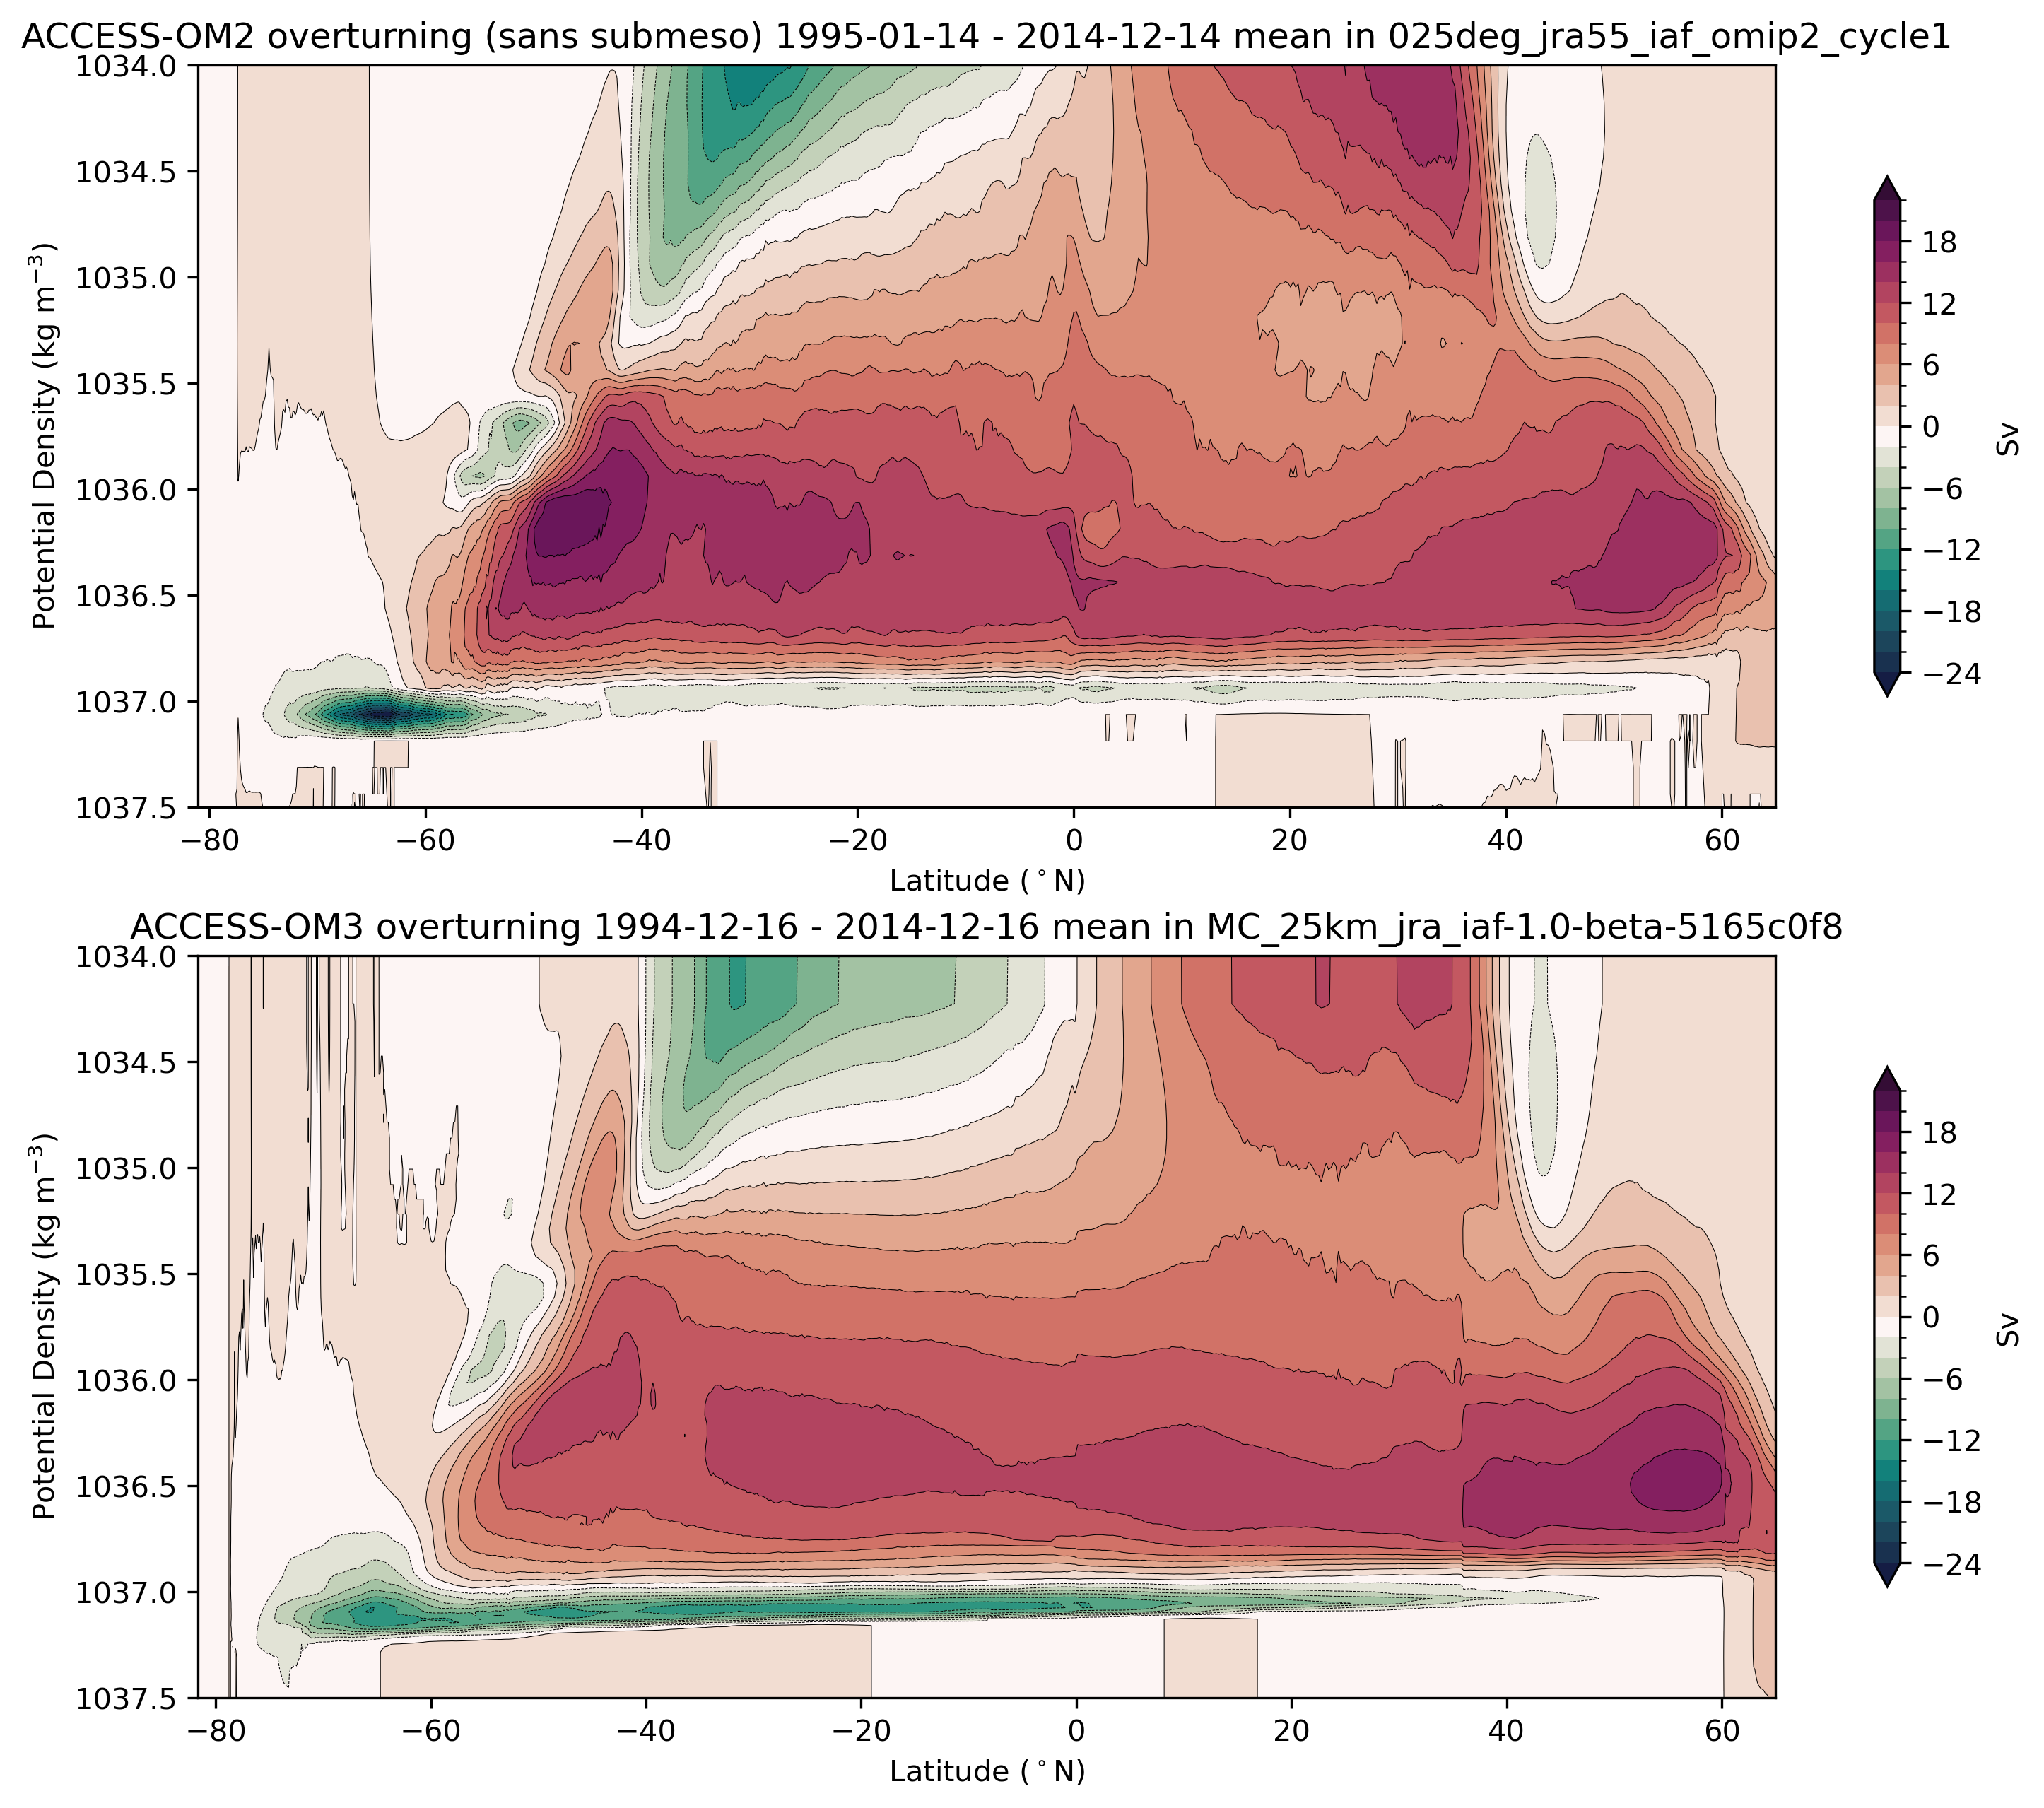

In [21]:
plt.figure(figsize=(12, 10))
levels = range(-24, 24, 2)
plt.subplot(211)
psi_OM2.plot.contourf(
    levels=levels, cmap=cm.cm.curl, extend="both",
    cbar_kwargs={"label": "Sv", "shrink": 0.7}
)
psi_OM2.plot.contour(levels=levels, colors="k", linewidths=0.25)
plt.gca().invert_yaxis()
plt.ylim((1037.5, 1034))
plt.ylabel("Potential Density (kg m$^{-3}$)")
plt.xlabel("Latitude ($^\circ$N)")
if ty_trans_rho_gm_all is not False:
    plt.title(f"{data_name} overturning (sans submeso) {OM2timestr} mean in {om2exptname}")
else:
    plt.title(f"{data_name} overturning (sans GM & submeso) {OM2timestr} mean in {om2exptname}")

plt.subplot(212)
psi_OM3.plot.contourf(
    levels=levels, cmap=cm.cm.curl, extend="both",
    cbar_kwargs={"label": "Sv", "shrink": 0.7}
)
psi_OM3.plot.contour(levels=levels, colors="k", linewidths=0.25)
plt.gca().invert_yaxis()
plt.ylim((1037.5, 1034))
plt.ylabel("Potential Density (kg m$^{-3}$)")
plt.xlabel("Latitude ($^\circ$N)")
plt.title(f"{model_name} overturning {OM3timestr} mean in {exptname}")

## Timeseries of overturning at key latitudes

In [22]:
%%time
psi_30S_OM3 = (
    psi_OM3_all.sel(yq=-30, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_26N_OM3 = (
    psi_OM3_all.sel(yq=26, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_55N_OM3 = (
    psi_OM3_all.sel(yq=5, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_abyss_OM3 = (
    -psi_OM3_all.sel(yq=-40, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .min(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)

CPU times: user 2min 11s, sys: 51 s, total: 3min 2s
Wall time: 12min 52s


In [23]:
%%time
psi_30S_OM2 = (
    psi_OM2_all
    .sel(grid_yu_ocean=-30, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .max(dim="potrho")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_26N_OM2 = (
    psi_OM2_all
    .sel(grid_yu_ocean=26, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .max(dim="potrho")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_55N_OM2 = (
    psi_OM2_all
    .sel(grid_yu_ocean=55, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .max(dim="potrho")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_abyss_OM2 = (
    -psi_OM2_all
    .sel(grid_yu_ocean=-40, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .min(dim="potrho")
    .resample(time = '1YE').mean('time')
    .load()
)

CPU times: user 2min 7s, sys: 38.6 s, total: 2min 46s
Wall time: 5min 7s


Text(0, 0.5, '')

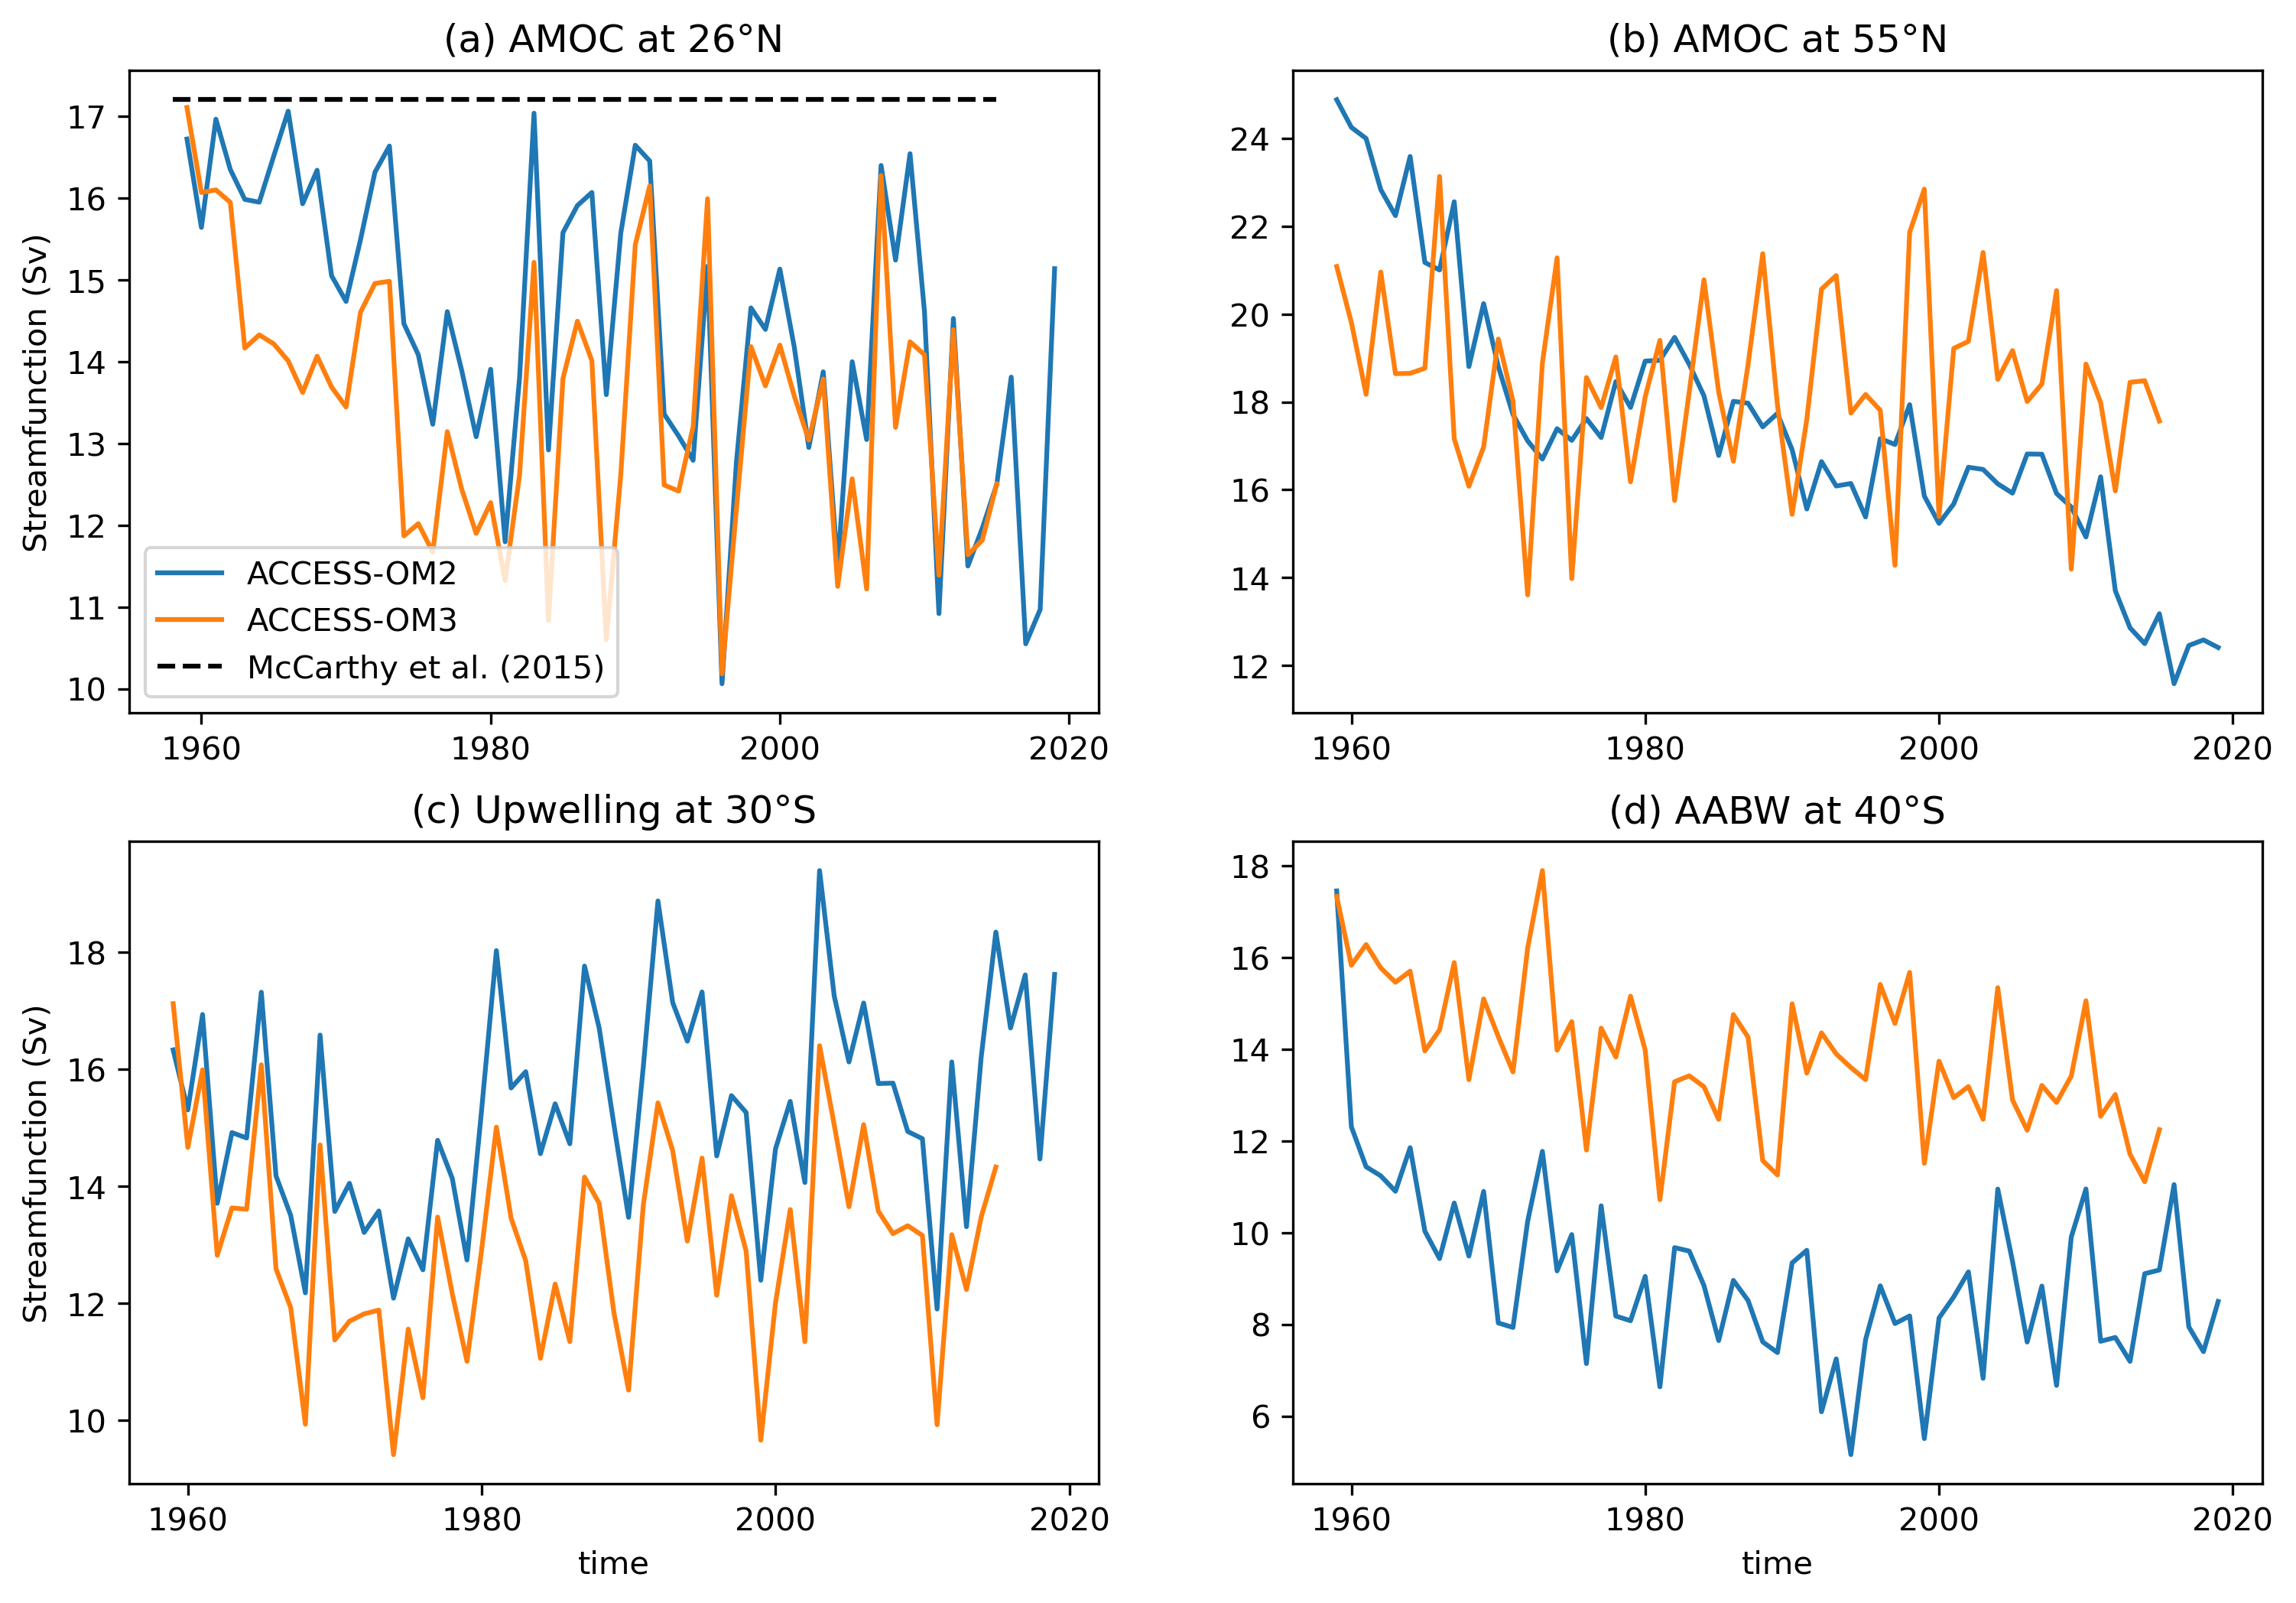

In [24]:
plt.figure(figsize=(12, 8)) 

plt.subplot(221)
psi_26N_OM2.plot(label=data_name)
psi_26N_OM3.plot(label=model_name)
plt.plot([psi_OM3_all.time.values[0], psi_OM3_all.time.values[-1]], [17.2, 17.2],
           'k--', label="McCarthy et al. (2015)")
# plt.plot([cftime.datetime(1900, 1, 1), cftime.datetime(1950, 12, 31)], [17.2, 17.2],
#            'k--', label="McCarthy et al. (2015)")
plt.title('(a) AMOC at 26°N')
plt.ylabel('Streamfunction (Sv)')
plt.legend()
plt.xlabel('')

plt.subplot(222)
psi_55N_OM2.plot()
psi_55N_OM3.plot()
plt.title('(b) AMOC at 55°N')
plt.ylabel('')
plt.xlabel('')

plt.subplot(223)
psi_30S_OM2.plot()
psi_30S_OM3.plot()
plt.title('(c) Upwelling at 30°S')
plt.ylabel('Streamfunction (Sv)')

plt.subplot(224)
psi_abyss_OM2.plot()
psi_abyss_OM3.plot()
plt.title('(d) AABW at 40°S')
plt.ylabel('')

In [25]:
client.close()